# 1. Introduction to Unsupervised Learning

- Unsupervised Learning is used when we don't have labels in our dataset.

### CASE 1:
- Suppose we have a dataset which looks like below
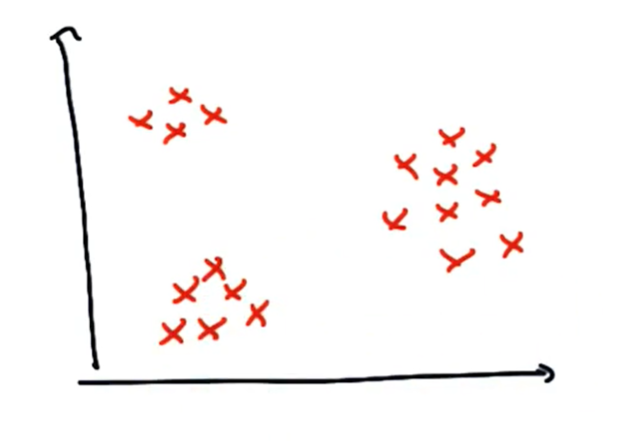

- It looks like there are certain clusters or clumps in the data. If we could identify those clusters or clumps, we could may be say something about unknown data points or how the neighbours might look like
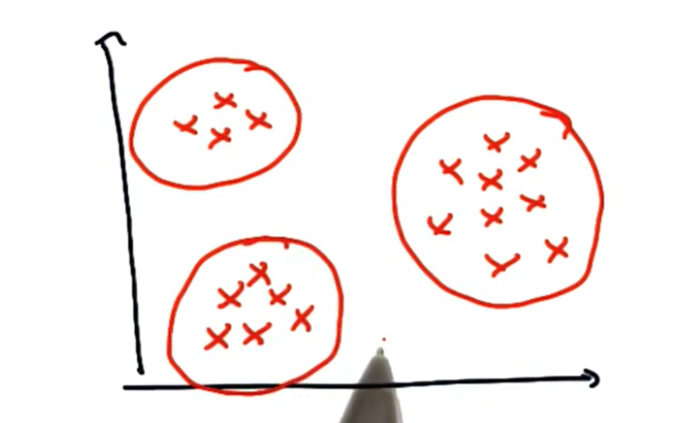

### CASE 2:
- Suppose we have a dataset which looks like below
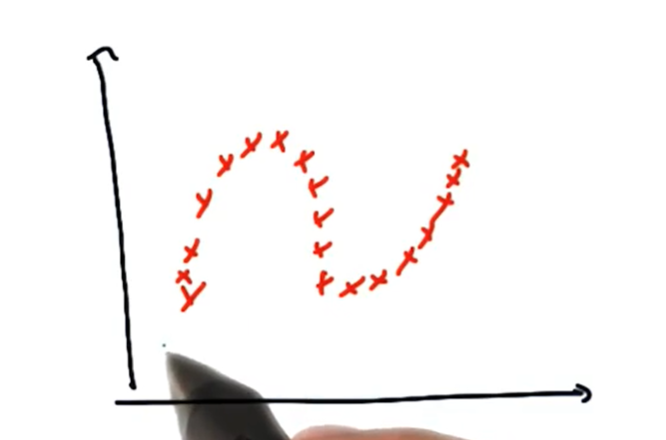

- It looks like all points might reside on some kind of complicate shape
- Some points can be reduced to one dimensional space called "Dimensionality Reduction"
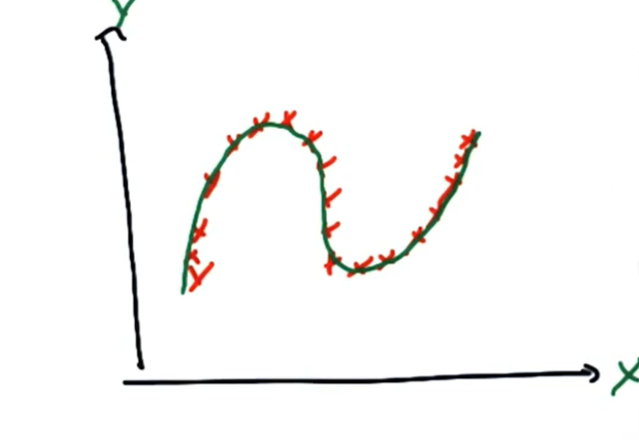

# 2. Clustering

- Suppose both of them have movies collection
- Both of them have different tastes and preferences 
- Sebastian finds some movies 'Great' but Katie finds them 'Bad' and vice-versa
- We could conclude that there are two different classes of movies
- Netflix would suggest something from 'Class B' to Katie and something from 'Class A' to Sebastian
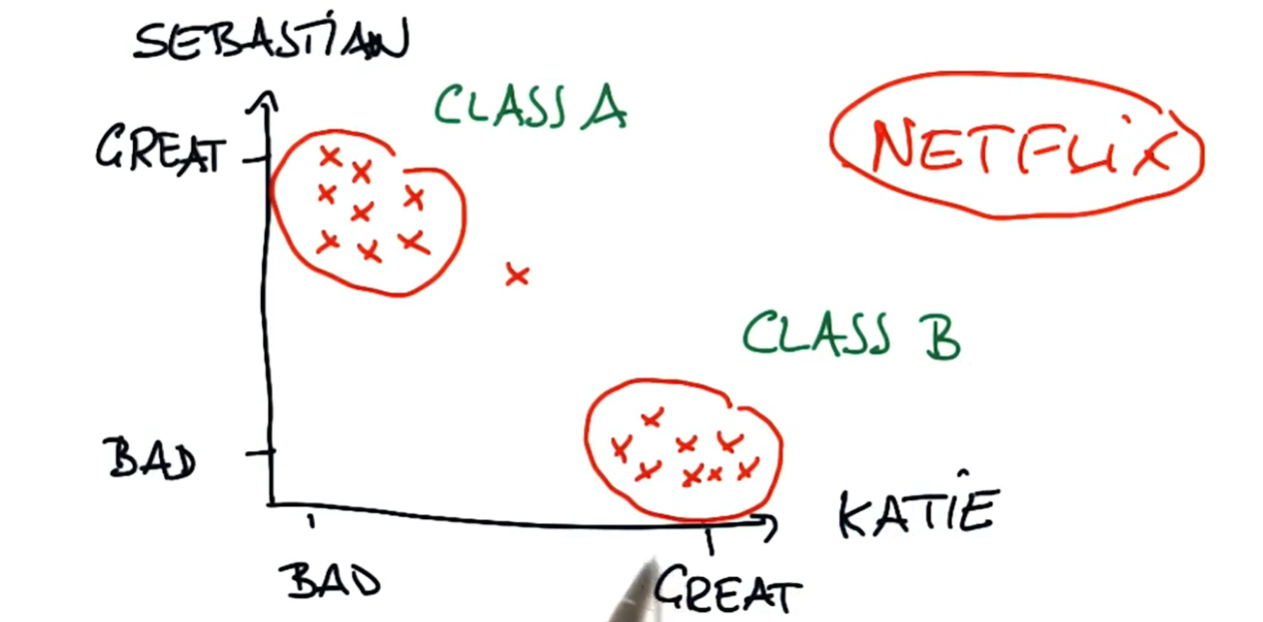

# 3. K-Means Clustering

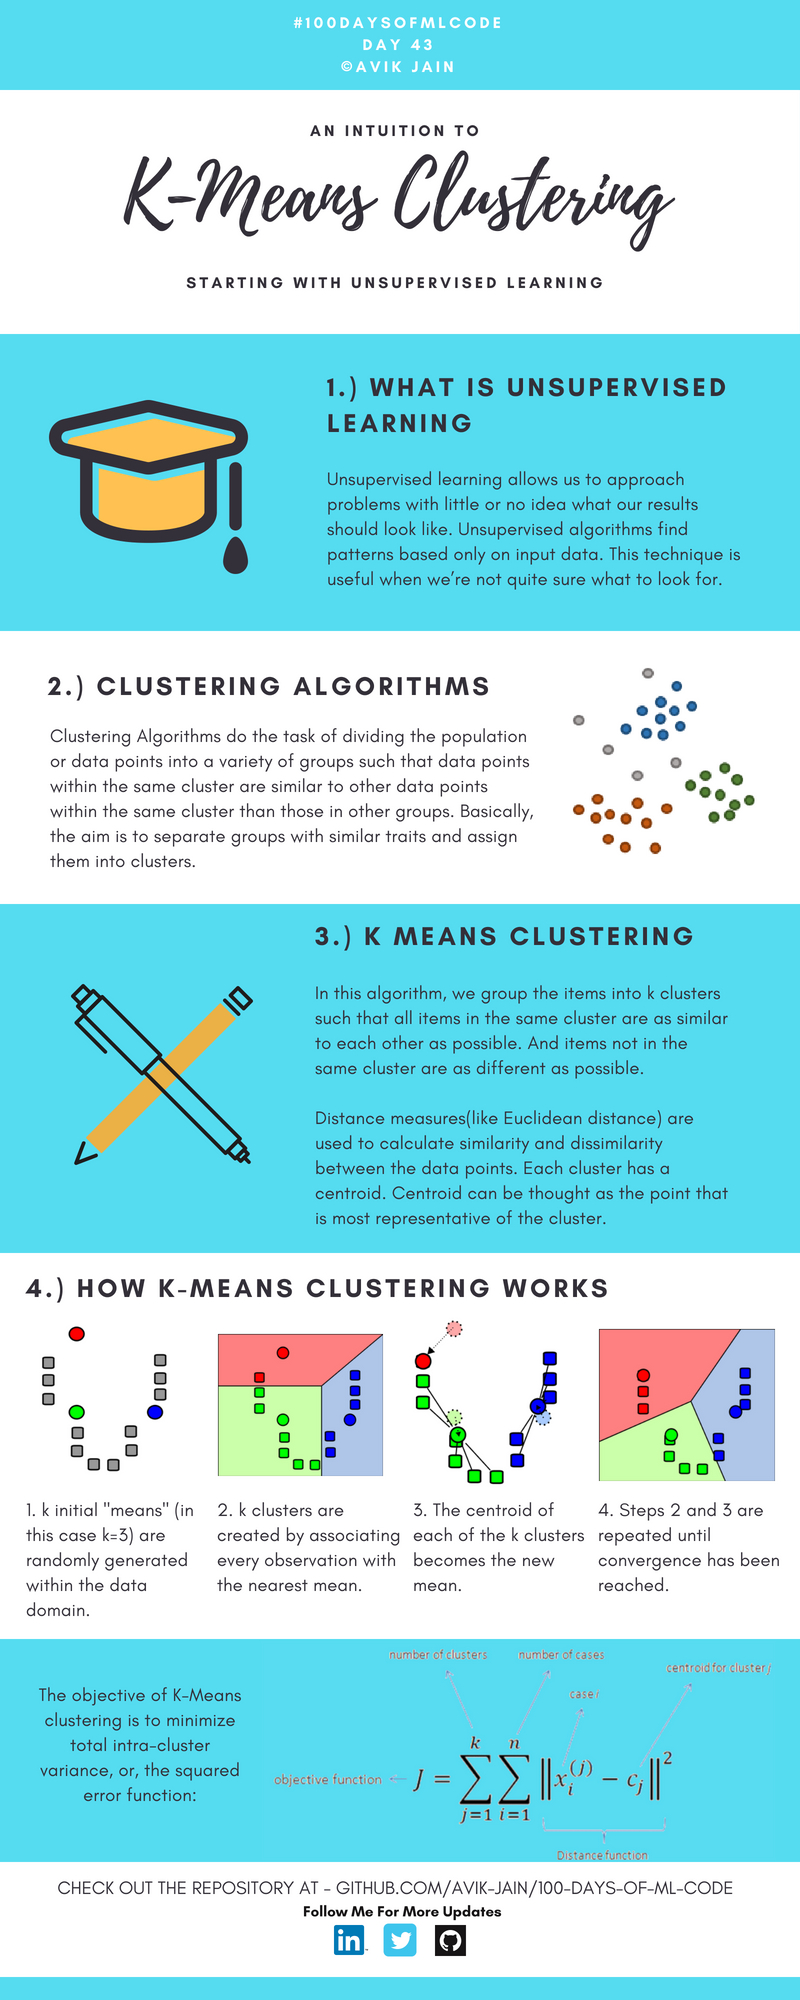

- A cluster refers to a collection of data points aggregated together because of certain similarities.
- You’ll define a target number k, which refers to the number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster.
- Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.
- In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.
- The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

### Example 1:
- Suppose we have a dataset like below. It seems, there are 2 clusters in the data.
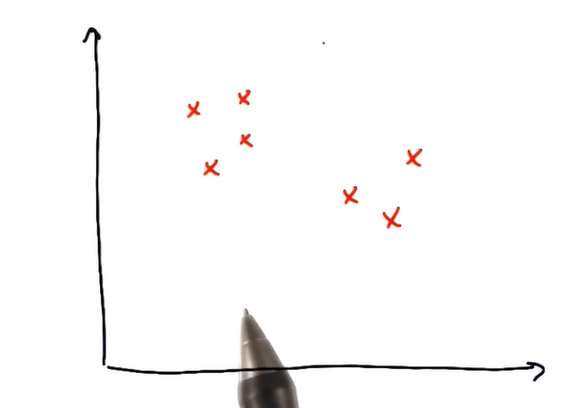

- In k-means, first you draw randomly clusters centre and then try to optimize them.
- It seems first 4 points are closest to cluster centre 1 and others are closest to cluster centre 2
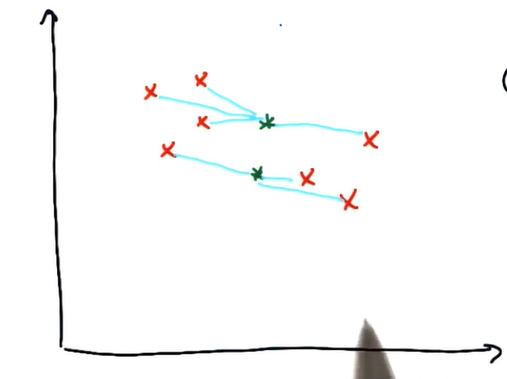

- Now we will try to optimize i.e. we try to minimize the total quadratic error
- Re-assign the location of new cluster such that we minimize the total quadratic error
- Then, we will re-match the data points to the cluster centre such that the distance between them is minimum
- After a few iterations, the centroids to those clusters would look something like below
- This is called 'K-means Algorithm'
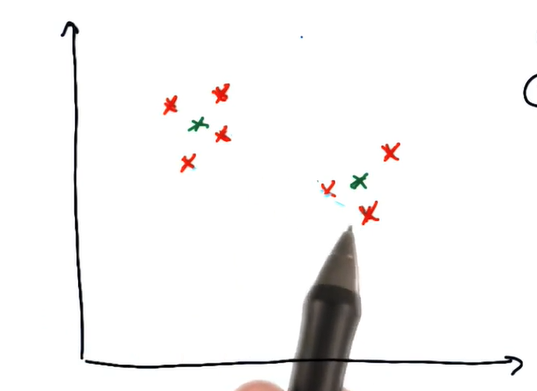

# 4. Clustering in sklearn

### Parameters:
1. n_clusters = number of clusters
2. max_iter = maximum number of iterations
3. n_init = number of different initialization you give in

# 5. Limitations of K-Means

- Intialization of clusters matters for the output i.e. the output for any given training set will not always same and will be dependent on initial location of the clusters.
- Number of clusters also matters for the output cluster centroid
- It is possible to have bad local minima i.e. not end up at any optima, when the intial cluster centroids are on the top of each other

# 6. Project: k-means Clustering of Movie Ratings

Say you're a data analyst at Netflix and you want to explore the similarities and differences in people's tastes in movies based on how they rate different movies. Can understanding these ratings contribute to a movie recommendation system for users? Let's dig into the data and see.

The data we'll be using comes from the wonderful [MovieLens](https://movielens.org/) [user rating dataset](https://grouplens.org/datasets/movielens/). We'll be looking at individual movie ratings later in the notebook, but let us start with how ratings of genres compare to each other.

## Dataset overview
The dataset has two files. We'll import them both into pandas dataframes:

In [66]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [67]:
# Import the movies dataset
movies = pd.read_csv('movies.csv')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [68]:
# Import the ratings dataset
ratings = pd.read_csv('ratings.csv')
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [69]:
# Finding the number of records in each of these tables
print('The dataset contains:', len(ratings), 'ratings of', len(movies), 'movies.')

The dataset contains: 100004 ratings of 9125 movies.


# Romance vs. Scifi

In [70]:
def get_genre_ratings(ratings, movies, genres, column_names):
    genre_ratings = pd.DataFrame()
    for genre in genres:        
        genre_movies = movies[movies['genres'].str.contains(genre) ]
        avg_genre_votes_per_user = ratings[ratings['movieId'].isin(genre_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
        
        genre_ratings = pd.concat([genre_ratings, avg_genre_votes_per_user], axis=1)
        
    genre_ratings.columns = column_names
    return genre_ratings

In [71]:
# Calculate the average rating of romance and scifi movies
genre_ratings = get_genre_ratings(ratings, movies, ['Romance', 'Sci-Fi'], ['avg_romance_rating', 'avg_scifi_rating'])
print( "Number of records: ", len(genre_ratings))
genre_ratings.head()

Number of records:  671


,avg_romance_rating,avg_scifi_rating
userId,,
1,3.50,2.40
2,3.59,3.80
3,3.65,3.14
4,4.50,4.26
5,4.08,4.00


- The function `get_genre_ratings` calculated each user's average rating of all romance movies and all scifi movies. 

- Now, let's bias our dataset a little by removing people who like both scifi and romance, just so that our clusters tend to define them as liking one genre more than the other.

In [72]:
def bias_genre_rating_dataset(genre_ratings, score_limit_1, score_limit_2):
    biased_dataset = genre_ratings[((genre_ratings['avg_romance_rating'] < score_limit_1 - 0.2) & (genre_ratings['avg_scifi_rating'] > score_limit_2)) | ((genre_ratings['avg_scifi_rating'] < score_limit_1) & (genre_ratings['avg_romance_rating'] > score_limit_2))]
    biased_dataset = pd.concat([biased_dataset[:300], genre_ratings[:2]])
    biased_dataset = pd.DataFrame(biased_dataset.to_records())
    return biased_dataset

In [73]:
biased_dataset = bias_genre_rating_dataset(genre_ratings, 3.2, 2.5)
print( "Number of records: ", len(biased_dataset))
biased_dataset.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating
0,1,3.50,2.40
1,3,3.65,3.14
2,6,2.90,2.75
3,7,2.93,3.36
4,12,2.89,2.62


- So, we can see we have 183 users, and for each user we have their average rating of the romance and sci movies they've watched.

In [74]:
def draw_scatterplot(x_data, x_label, y_data, y_label):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x_data, y_data, s=30)

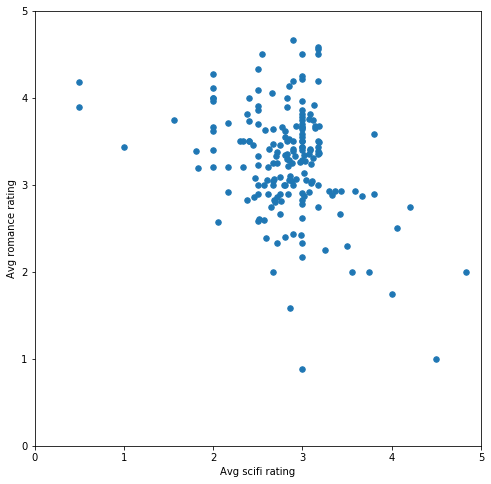

In [75]:
draw_scatterplot(biased_dataset['avg_scifi_rating'],'Avg scifi rating', biased_dataset['avg_romance_rating'], 'Avg romance rating')

- we can see some clear bias in this sample (that we created on purpose)

- Now, focus on, how would it look if we break the sample down into two groups using k-means

In [76]:
# Let's turn our dataset into a list
X = biased_dataset[['avg_scifi_rating', 'avg_romance_rating']].values

In [77]:
def draw_clusters(biased_dataset, predictions, cmap='viridis'):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')
    

    clustered = pd.concat([biased_dataset.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
    plt.scatter(clustered['avg_scifi_rating'], clustered['avg_romance_rating'], c=clustered['group'], s=20, cmap=cmap)

In [78]:
# Import KMeans
from sklearn.cluster import KMeans

In [79]:
# Create an instance of KMeans to find two clusters
kmeans_1 = KMeans(n_clusters=2)

In [80]:
# Use fit_predict to cluster the dataset
predictions = kmeans_1.fit_predict(X) 

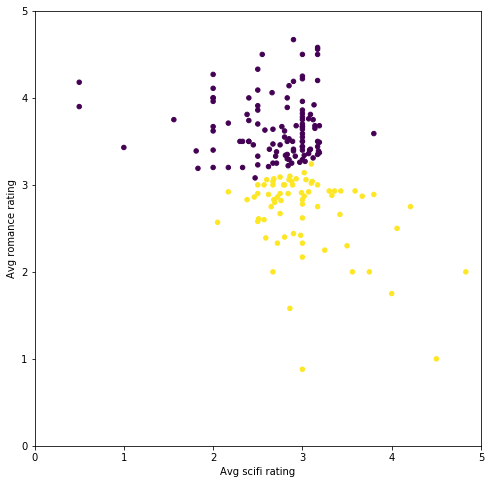

In [81]:
# Plot
draw_clusters(biased_dataset, predictions)

- We can see that the groups are mostly based on how each person rated romance movies.
- If their average rating of romance movies is over 3 stars, then they belong to one group.
- Otherwise, they belong to the other group.

- What would happen if we break them down into three groups?

In [82]:
# Create an instance of KMeans to find three clusters
kmeans_2 = KMeans(n_clusters=3)

In [83]:
# Use fit_predict to cluster the dataset
predictions_2 = kmeans_2.fit_predict(X)

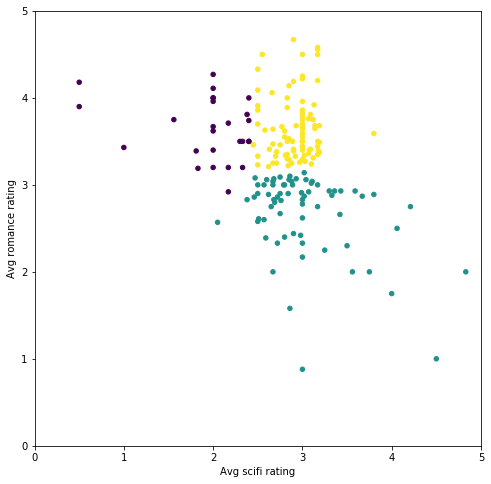

In [84]:
# Plot
draw_clusters(biased_dataset, predictions_2)

Now the average scifi rating is starting to come into play. The groups are:
 * people who like romance but not scifi
 * people who like scifi but not romance
 * people who like both scifi and romance

- Let's add one more group

In [85]:
# Create an instance of KMeans to find three clusters
kmeans_3 = KMeans(n_clusters=4)

In [86]:
# Use fit_predict to cluster the dataset
predictions_3 = kmeans_3.fit_predict(X)

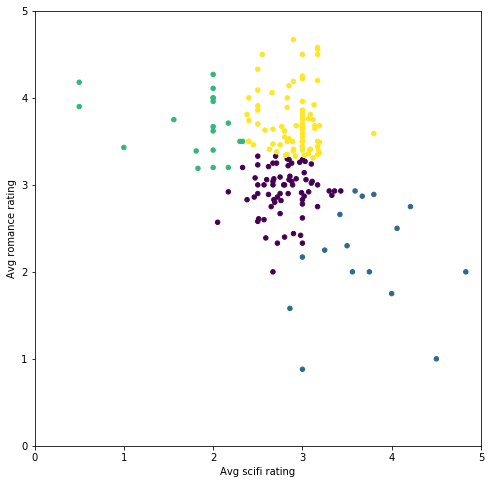

In [87]:
# Plot
draw_clusters(biased_dataset, predictions_3)

- We can see that the more clusters we break our dataset down into, the more similar the tastes of the population of each cluster to each other.

## Choosing K
- Great, so we can cluster our points into any number of clusters.
- But, What's the right number of clusters for this dataset?
- There are [several](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set) ways of choosing the number of clusters, k. We'll look at a simple one called "the elbow method". The elbow method works by plotting the ascending values of k versus the total error calculated using that k. 

### How do we calculate total error?
- One way to calculate the error is squared error. Say we're calculating the error for k=2. We'd have two clusters each having one "centroid" point.
- For each point in our dataset, we'd subtract its coordinates from the centroid of the cluster it belongs to.
- We then square the result of that subtraction (to get rid of the negative values), and sum the values. This would leave us with an error value for each point. If we sum these error values, we'd get the total error for all points when k=2.
- Our mission now is to do the same for each k (between 1 and, say, the number of elements in our dataset)

In [88]:
df = biased_dataset[['avg_scifi_rating','avg_romance_rating']]

In [89]:
# We added a stride of 5 to improve performance. We don't need to calculate the error for every k value
possible_k_values = range(2, len(X)+1, 5)
possible_k_values

range(2, 184, 5)

In [90]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [91]:
def clustering_errors(k, data):
    kmeans = KMeans(n_clusters=k).fit(data)
    predictions = kmeans.predict(data)
    #cluster_centers = kmeans.cluster_centers_
    # errors = [mean_squared_error(row, cluster_centers[cluster]) for row, cluster in zip(data.values, predictions)]
    # return sum(errors)
    silhouette_avg = silhouette_score(data, predictions)
    return silhouette_avg

In [92]:
# Calculate error values for all k values we're interested in
errors_per_k = [clustering_errors(k, X) for k in possible_k_values]

In [93]:
# Look at the values of K vs the silhouette score of running K-means with that value of k
list(zip(possible_k_values, errors_per_k))

[(2, 0.35588178764728268),
 (7, 0.38668213231290249),
 (12, 0.34636514815769065),
 (17, 0.37184379430971037),
 (22, 0.37348504866564619),
 (27, 0.36554272373819968),
 (32, 0.37527783452833613),
 (37, 0.36115463525890534),
 (42, 0.37440545783814921),
 (47, 0.37662255189990501),
 (52, 0.36746093976155192),
 (57, 0.36880267336184425),
 (62, 0.37115513040580367),
 (67, 0.34523536545975103),
 (72, 0.35230245097833579),
 (77, 0.33977434697750397),
 (82, 0.34662831377628528),
 (87, 0.33008656295160416),
 (92, 0.34386368693382696),
 (97, 0.31512371116540644),
 (102, 0.31194262387734289),
 (107, 0.29825540180486992),
 (112, 0.28682218171240875),
 (117, 0.27516775642303443),
 (122, 0.27225643918539455),
 (127, 0.26333383525297943),
 (132, 0.24493083422935197),
 (137, 0.23764783244855908),
 (142, 0.21896425495445121),
 (147, 0.20458550834106112),
 (152, 0.17623862965244744),
 (157, 0.1662404161186051),
 (162, 0.1556499460287056),
 (167, 0.12920960729960135),
 (172, 0.10075966098920461),
 (177, 0.

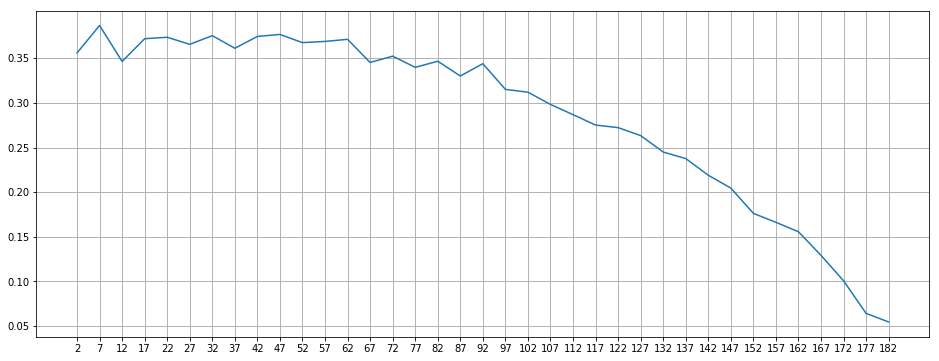

In [94]:
# Plot the each value of K vs. the silhouette score at that value
fig, ax = plt.subplots(figsize=(16, 6))
plt.plot(possible_k_values, errors_per_k)

# Ticks and grid
xticks = np.arange(min(possible_k_values), max(possible_k_values)+1, 5.0)
ax.set_xticks(xticks, minor=False)
ax.set_xticks(xticks, minor=True)
ax.xaxis.grid(True, which='both')
yticks = np.arange(round(min(errors_per_k), 2), max(errors_per_k), .05)
ax.set_yticks(yticks, minor=False)
ax.set_yticks(yticks, minor=True)
ax.yaxis.grid(True, which='both')

- Looking at this graph, good choices for k include 7, 22, 27, 32, amongst other values (with a slight variation between different runs).
- Increasing the number of clusters (k) beyond that range starts to result in worse clusters (according to Silhouette score)

- My pick would be k=7 because it's easier to visualize:

In [95]:
# Create an instance of KMeans to find seven clusters
kmeans_4 = KMeans(n_clusters=7)

In [96]:
# Use fit_predict to cluster the dataset
predictions_4 = kmeans_4.fit_predict(X)

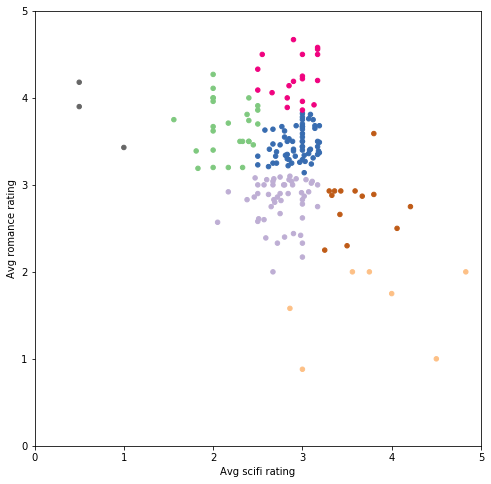

In [97]:
# Plot
draw_clusters(biased_dataset, predictions_4, cmap='Accent')

- Note: As you try to plot larger values of k (more than 10), you'll have to make sure your plotting library is not reusing colors between clusters. For this plot, we had to use the [matplotlib colormap](https://matplotlib.org/examples/color/colormaps_reference.html) 'Accent' because other colormaps either did not show enough contrast between colors, or were recycling colors past 8 or 10 clusters.

## Throwing some Action into the mix
So far, we've only been looking at how users rated romance and scifi movies. Let's throw another genre into the mix. Let's add the Action genre.

In [98]:
biased_dataset_3_genres = get_genre_ratings(ratings, movies, 
                                                     ['Romance', 'Sci-Fi', 'Action'], 
                                                     ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating'])

In [99]:
biased_dataset_3_genres = bias_genre_rating_dataset(biased_dataset_3_genres, 3.2, 2.5).dropna()

In [100]:
print( "Number of records: ", len(biased_dataset_3_genres))
biased_dataset_3_genres.head()

Number of records:  183


,userId,avg_romance_rating,avg_scifi_rating,avg_action_rating
0,1,3.50,2.40,2.80
1,3,3.65,3.14,3.47
2,6,2.90,2.75,3.27
3,7,2.93,3.36,3.29
4,12,2.89,2.62,3.21


In [101]:
X_with_action = biased_dataset_3_genres[['avg_scifi_rating',
                                                           'avg_romance_rating', 
                                                           'avg_action_rating']].values
X_with_action

array([[ 2.4 ,  3.5 ,  2.8 ],
       [ 3.14,  3.65,  3.47],
       [ 2.75,  2.9 ,  3.27],
       [ 3.36,  2.93,  3.29],
       [ 2.62,  2.89,  3.21],
       [ 2.51,  2.61,  2.48],
       [ 3.12,  3.31,  3.31],
       [ 3.07,  3.76,  3.31],
       [ 3.17,  3.  ,  3.  ],
       [ 3.  ,  0.88,  3.5 ],
       [ 2.83,  3.3 ,  3.06],
       [ 2.17,  2.92,  2.88],
       [ 3.  ,  4.25,  3.5 ],
       [ 2.7 ,  3.33,  2.71],
       [ 2.  ,  3.96,  3.5 ],
       [ 3.12,  3.75,  3.33],
       [ 2.65,  2.75,  2.58],
       [ 3.09,  3.41,  2.99],
       [ 3.43,  2.93,  3.39],
       [ 2.72,  2.33,  2.55],
       [ 2.5 ,  4.33,  2.86],
       [ 2.77,  3.67,  2.98],
       [ 2.89,  3.  ,  3.04],
       [ 2.93,  3.68,  3.03],
       [ 3.02,  2.87,  2.58],
       [ 2.38,  3.81,  2.86],
       [ 4.06,  2.5 ,  3.96],
       [ 3.17,  3.35,  3.23],
       [ 3.  ,  2.17,  2.69],
       [ 0.5 ,  4.18,  1.25],
       [ 3.14,  3.68,  3.08],
       [ 2.75,  3.09,  2.55],
       [ 3.  ,  4.22,  3.75],
       [ 2

In [102]:
def get_dataset_3(movies, ratings, genre_ratings):    
    # Extract action ratings from dataset
    action_movies = movies[movies['genres'].str.contains('Action') ]
    # Get average vote on action movies per user
    avg_action_votes_per_user = ratings[ratings['movieId'].isin(action_movies['movieId'])].loc[:, ['userId', 'rating']].groupby(['userId'])['rating'].mean().round(2)
    # Add action ratings to romance and scifi in dataframe
    genre_ratings_3 = pd.concat([genre_ratings, avg_action_votes_per_user], axis=1)
    genre_ratings_3.columns = ['avg_romance_rating', 'avg_scifi_rating', 'avg_action_rating']
    
    # Let's bias the dataset a little so our clusters can separate scifi vs romance more easily
    b1 = 3.2
    b2 = 2.5
    biased_dataset_3 = genre_ratings_3[((genre_ratings_3['avg_romance_rating'] < b1 - 0.2) & (genre_ratings_3['avg_scifi_rating'] > b2)) | ((genre_ratings_3['avg_scifi_rating'] < b1) & (genre_ratings_3['avg_romance_rating'] > b2))]
    biased_dataset_3 = pd.concat([biased_dataset_3[:300], genre_ratings_3[:2]])
    biased_dataset_3 = pd.DataFrame(biased_dataset_3.to_records())
    
    return biased_dataset_3

In [103]:
import itertools

In [104]:
def draw_clusters_3d(biased_dataset_3, predictions):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)

    plt.xlim(0, 5)
    plt.ylim(0, 5)
    ax.set_xlabel('Avg scifi rating')
    ax.set_ylabel('Avg romance rating')

    clustered = pd.concat([biased_dataset_3.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

    colors = itertools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

    for g in clustered.group.unique():
        color = next(colors)
        for index, point in clustered[clustered.group == g].iterrows():
            if point['avg_action_rating'].astype(float) > 3: 
                size = 50
            else:
                size = 15
            plt.scatter(point['avg_scifi_rating'], 
                        point['avg_romance_rating'], 
                        s=size, 
                        color=color)

In [105]:
# Create an instance of KMeans to find seven clusters
kmeans_5 = KMeans(n_clusters=7)

In [106]:
# Use fit_predict to cluster the dataset
predictions_5 = kmeans_5.fit_predict(X_with_action)

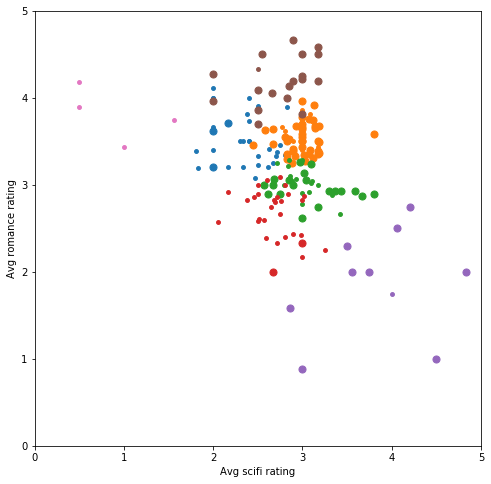

In [107]:
# plot
draw_clusters_3d(biased_dataset_3_genres, predictions_5)

- We're still using the x and y axes for scifi and romance respectively. We are using the size of the dot to roughly code the 'action' rating (large dot for avg ratings over than 3, small dot otherwise).

- We can start seeing the added genre is changing how the users are clustered. The more data we give to k-means, the more similar the tastes of the people in each group would be.
- Unfortunately, though, we lose the ability to visualize what's going on past two or three dimensions if we continue to plot it this way. In the next section, we'll start using a different kind of plot to be able to see clusters with up to fifty dimensions.

## Movie-level Clustering
- Now that we've established some trust in how k-means clusters users based on their genre tastes, let's take a bigger bite and look at how users rated individual movies.
- To do that, we'll shape the dataset in the form of `userId vs user rating for each movie`. For example, let's look at a subset of the dataset:

In [108]:
# Merge the two tables then pivot so we have Users X Movies dataframe
ratings_title = pd.merge(ratings, movies[['movieId', 'title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')

In [109]:
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 9064) 

Subset example:


title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009)
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN


- The dominance of NaN values presents the first issue. Most users have not rated and watched most movies. Datasets like this are called "sparse" because only a small number of cells have values. 

- To get around this, let's sort by the most rated movies, and the users who have rated the most number of movies. That will present a more 'dense' region when we peak at the top of the dataset.

- If we're to choose the most-rated movies vs users with the most ratings, it would look like this:

In [110]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [111]:
def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

In [112]:
def sort_by_rating_density(user_movie_ratings, n_movies, n_users):
    most_rated_movies = get_most_rated_movies(user_movie_ratings, n_movies)
    most_rated_movies = get_users_who_rate_the_most(most_rated_movies, n_users)
    return most_rated_movies

In [113]:
n_movies = 30
n_users = 18
most_rated_movies_users_selection = sort_by_rating_density(user_movie_ratings, n_movies, n_users)

print('dataset dimensions: ', most_rated_movies_users_selection.shape)
most_rated_movies_users_selection.head()

dataset dimensions:  (18, 30)


title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Dances with Wolves (1990),Fight Club (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),"Lion King, The (1994)","Godfather, The (1972)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Apollo 13 (1995),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
29,5.0,5.0,5.0,4.0,4.0,4.0,3.0,4.0,5.0,4.0,...,5.0,4.0,5.0,4.0,3.0,5.0,3.0,5.0,4.0,2.0
508,4.0,5.0,4.0,4.0,5.0,3.0,4.5,3.0,5.0,2.0,...,5.0,4.0,5.0,4.0,3.5,5.0,4.5,3.0,2.0,4.0
14,1.0,5.0,2.0,5.0,5.0,3.0,5.0,2.0,4.0,4.0,...,3.0,5.0,5.0,5.0,4.0,5.0,5.0,3.0,4.0,4.0
72,5.0,5.0,5.0,4.5,4.5,4.0,4.5,5.0,5.0,3.0,...,4.5,5.0,5.0,5.0,5.0,5.0,5.0,3.5,3.0,5.0
653,4.0,5.0,5.0,4.5,5.0,4.5,5.0,5.0,5.0,5.0,...,4.5,5.0,5.0,4.5,5.0,4.5,5.0,5.0,4.0,5.0


That's more like it. Let's also establish a good way for visualizing these ratings so we can attempt to visually recognize the ratings (and later, clusters) when we look at bigger subsets.

Let's use colors instead of the number ratings:

In [114]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [115]:
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()

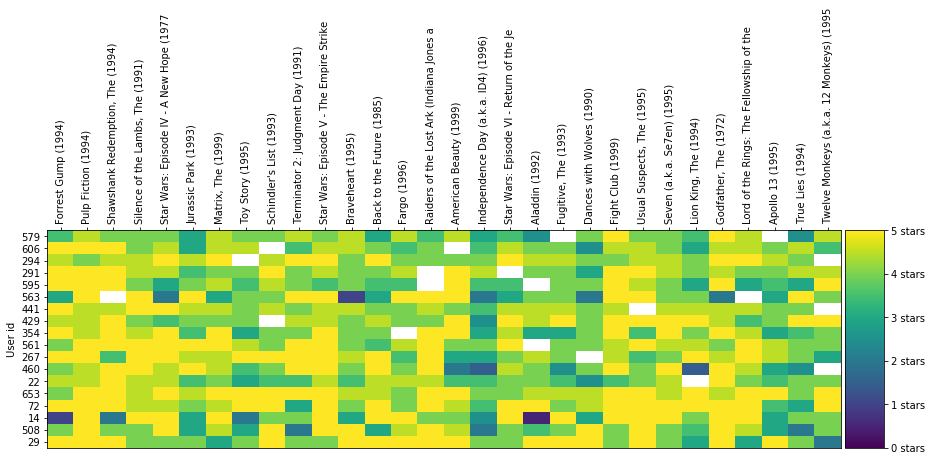

In [116]:
draw_movies_heatmap(most_rated_movies_users_selection)

- Each column is a movie. Each row is a user. The color of the cell is how the user rated that movie based on the scale on the right of the graph.

- Notice how some cells are white? This means the respective user did not rate that movie. This is an issue you'll come across when clustering in real life. Unlike the clean example we started with, real-world datasets can often be sparse and not have a value in each cell of the dataset. This makes it less straightforward to cluster users directly by their movie ratings as k-means generally does not like missing values.

- For performance reasons, we'll only use ratings for 1000 movies (out of the 9000+ available in the dataset).

In [117]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

In [118]:
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'title', values='rating')
user_movie_ratings

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),...,Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931),İtirazım Var (2014)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)
most_rated_movies_1k

title,Forrest Gump (1994),Pulp Fiction (1994),"Shawshank Redemption, The (1994)","Silence of the Lambs, The (1991)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),"Matrix, The (1999)",Toy Story (1995),Schindler's List (1993),Terminator 2: Judgment Day (1991),...,Insomnia (2002),What Lies Beneath (2000),Roman Holiday (1953),"Motorcycle Diaries, The (Diarios de motocicleta) (2004)",Sophie's Choice (1982),Dawn of the Dead (2004),Ocean's Thirteen (2007),Seabiscuit (2003),Easy Rider (1969),Lucky Number Slevin (2006)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,4.0,NaN,3.0,NaN,4.0,NaN,NaN,4.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,4.5,5.0,3.0,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3.0,NaN,5.0,NaN,5.0,4.0,NaN,3.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.0,4.0,5.0,4.5,3.5,NaN,5.0,NaN,5.0,4.0,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,4.0,4.0,NaN,NaN,5.0,4.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- To have sklearn run k-means clustering to a dataset with missing values like this, we will first cast it to the [sparse csr matrix](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.sparse.csr_matrix.html) type defined in the SciPi library. 

- To convert from a pandas dataframe to a sparse matrix, we'll have to convert to SparseDataFrame, then use pandas' `to_coo()` method for the conversion.

- Note: `to_coo()` was only added in later versions of pandas. If you run into an error with the next cell, make sure pandas is up to date.

In [120]:
from scipy.sparse import csr_matrix

In [121]:
sparse_ratings = csr_matrix(pd.SparseDataFrame(most_rated_movies_1k).to_coo())

## Let's cluster!
- With k-means, we have to specify k, the number of clusters. Let's arbitrarily try k=20 (A better way to pick k is as illustrated above with the elbow method. That would take some processing time to run, however.):

In [122]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(sparse_ratings)

To visualize some of these clusters, we'll plot each cluster as a heat map:

In [123]:
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        d = sort_by_rating_density(d, max_movies, max_users)
        
        d = d.reindex_axis(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex_axis(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: '.reindex_axis' is deprecated and will be removed in a future version. Use '.reindex' instead.
  if sys.path[0] == '':


cluster # 7
# of users in cluster: 283. # of users in plot: 70


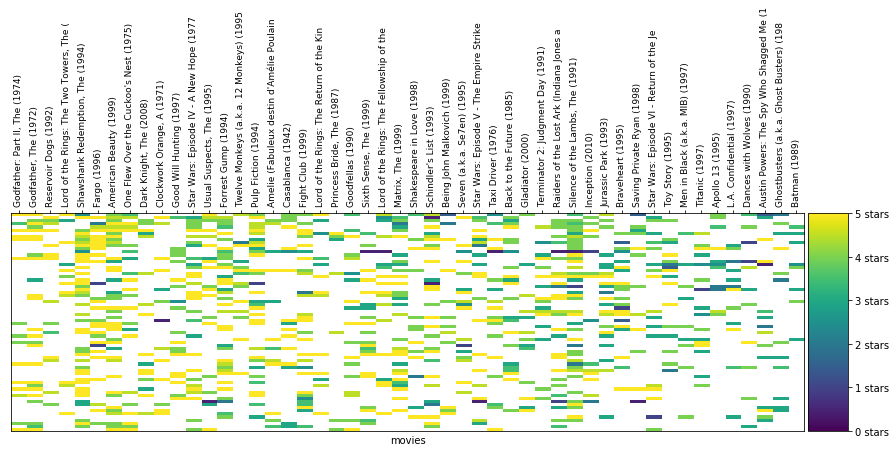

cluster # 6
# of users in cluster: 84. # of users in plot: 70


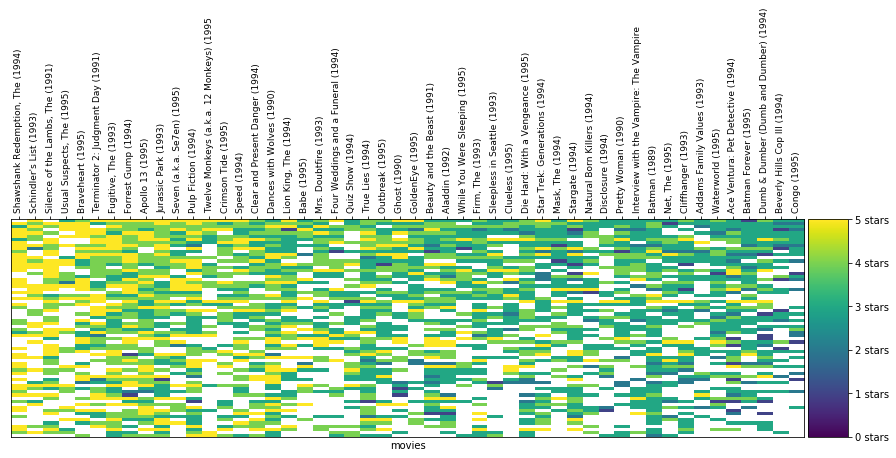

cluster # 13
# of users in cluster: 38. # of users in plot: 38


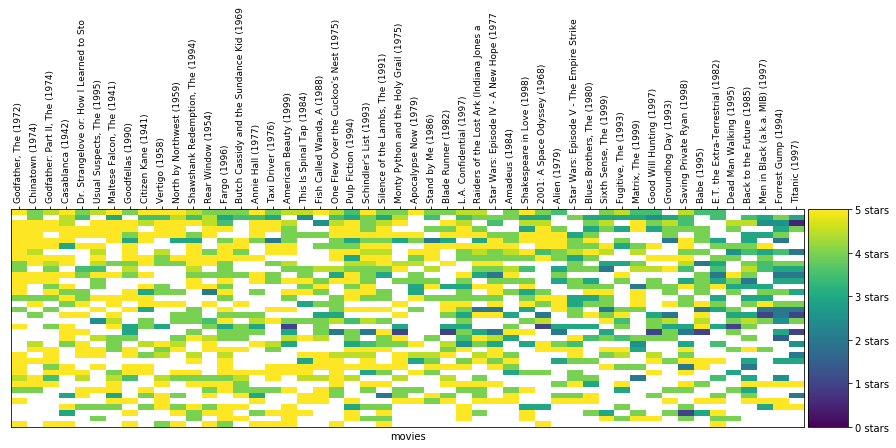

cluster # 2
# of users in cluster: 78. # of users in plot: 70


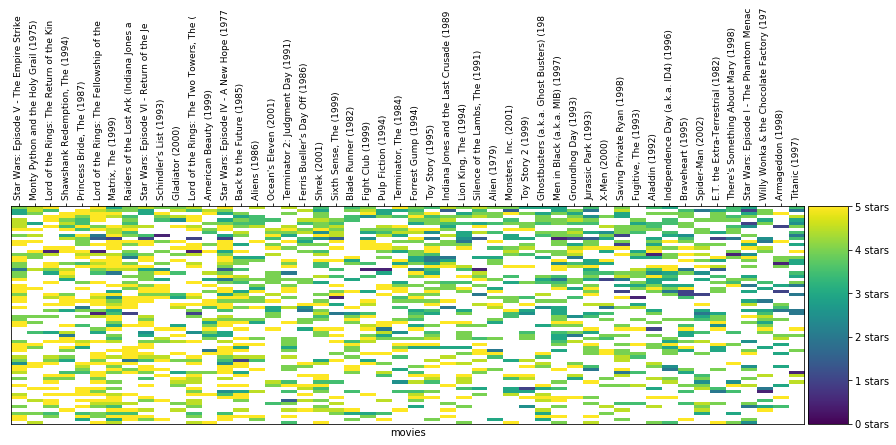

cluster # 11
# of users in cluster: 61. # of users in plot: 61


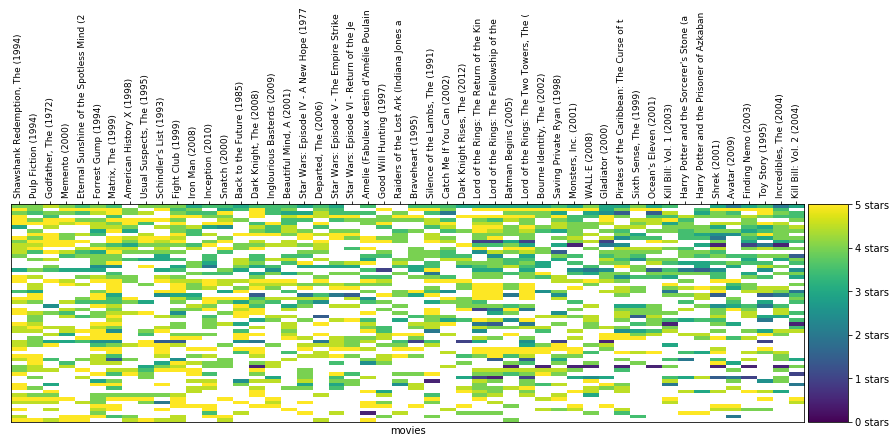

cluster # 10
# of users in cluster: 37. # of users in plot: 37


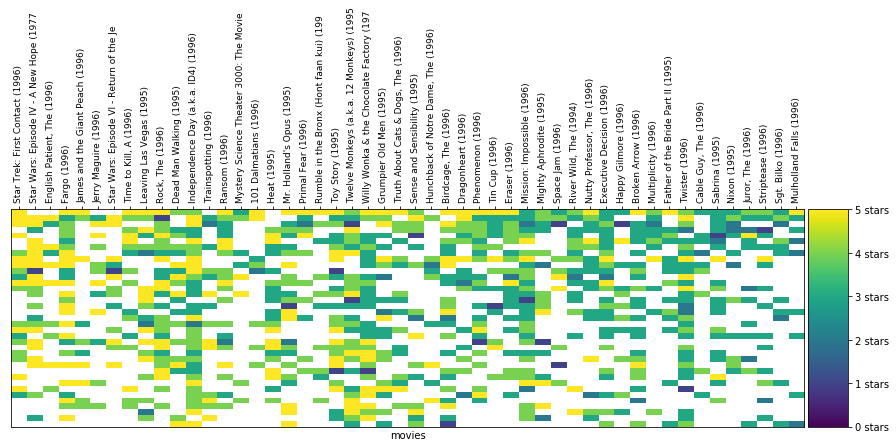

cluster # 3
# of users in cluster: 26. # of users in plot: 26


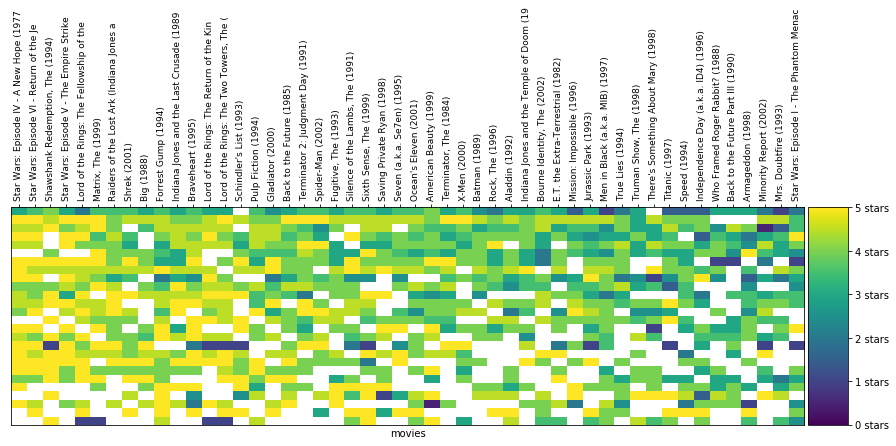

cluster # 18
# of users in cluster: 15. # of users in plot: 15


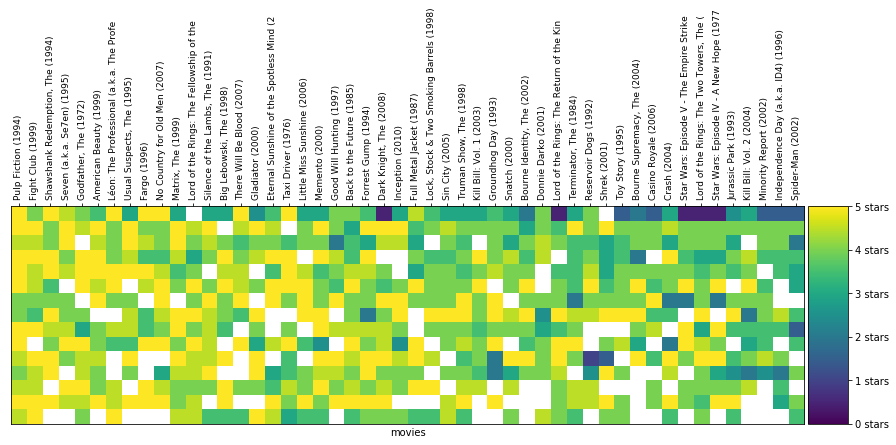

cluster # 19
# of users in cluster: 10. # of users in plot: 10


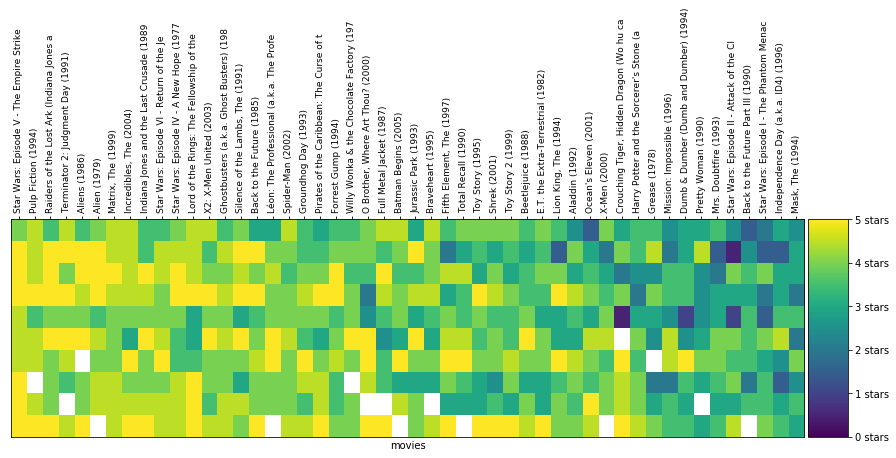

In [124]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)
draw_movie_clusters(clustered, max_users, max_movies)

There are several things to note here:
* The more similar the ratings in a cluster are, the more **vertical** lines in similar colors you'll be able to trace in that cluster. 
* It's super interesting to spot trends in clusters:
 * Some clusters are more sparse than others, containing people who probably watch and rate less movies than in other clusters.
 * Some clusters are mostly yellow and bring together people who really love a certain group of movies. Other clusters are mostly green or navy blue meaning they contain people who agree that a certain set of movoies deserves 2-3 stars.
 * Note how the movies change in every cluster. The graph filters the data to only show the most rated movies, and then sorts them by average rating.
 * Can you track where the Lord of the Rings movies appear in each cluster? What about Star Wars movies?
* It's easy to spot **horizontal** lines with similar colors, these are users without a lot of variety in their ratings. This is likely one of the reasons for Netflix switching from a stars-based ratings to a thumbs-up/thumbs-down rating. A rating of four stars means different things to different people.
* We did a few things to make the clusters visibile (filtering/sorting/slicing). This is because datasets like this are "sparse" and most cells do not have a value (because most people did not watch most movies). 

## Prediction
- Let's pick a cluster and a specific user and see what useful things this clustering will allow us to do.

- Let's first pick a cluster:

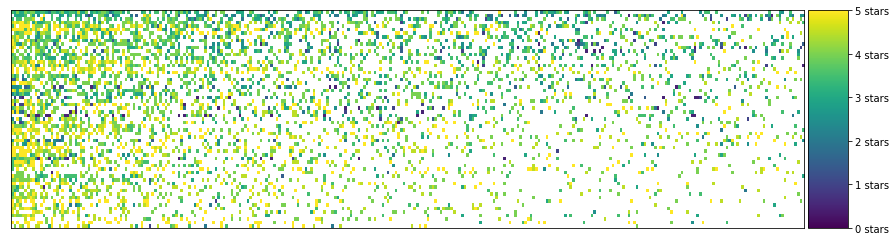

In [125]:
# Pick a cluster ID from the clusters above
cluster_number = 11

# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)

cluster = sort_by_rating_density(cluster, n_movies, n_users)
draw_movies_heatmap(cluster, axis_labels=False)

- And the actual ratings in the cluster look like this:

In [126]:
cluster.fillna('').head()

,"Matrix, The (1999)","Lord of the Rings: The Two Towers, The (2002)",Forrest Gump (1994),"Lord of the Rings: The Return of the King, The (2003)","Lord of the Rings: The Fellowship of the Ring, The (2001)",Fight Club (1999),"Dark Knight, The (2008)",Pulp Fiction (1994),"Shawshank Redemption, The (1994)",Pirates of the Caribbean: The Curse of the Black Pearl (2003),...,"Ring, The (2002)",Ocean's Thirteen (2007),"Lives of Others, The (Das leben der Anderen) (2006)",Back to the Future Part II (1989),"Others, The (2001)",Mean Girls (2004),Walk the Line (2005),Gangs of New York (2002),"South Park: Bigger, Longer and Uncut (1999)",Charlie's Angels (2000)
5,3.5,3,4,3,3,4,3.5,4,4,3,...,3,2.5,,,3.5,,,,,
20,,3,3,3,3,3.5,,4,3,,...,2.5,,,,3,2,,,2.5,2.5
12,3.5,,3.5,3.5,,4,4,4,4.5,,...,3.5,,,4,,4.5,,,4,
35,4.5,5,4.5,5,5,4,4.5,,3,4.5,...,4.5,,,,4.5,,,4.5,,3.5
50,3.5,5,,5,5,5,5,,5,4,...,,,,,,,,,,


In [127]:
# Fill in the name of the column/movie. e.g. 'Forrest Gump (1994)'
movie_name = "Matrix, The (1999)"

cluster[movie_name].mean()

4.2358490566037732

And this would be our prediction for how she'd rate the movie.

## Recommendation
Let's reiterate what we did in the previous step. We have used k-means to cluster users according to their ratings. This lead us to clusters of users with similar ratings and thus generally a similar taste in movies. Based on this, when one user did not have a rating for a certain movie  we averaged the ratings of all the other users in the cluster, and that was our guess to how this one user would like the movie.

Using this logic, if we calculate the average score in this cluster for every movie, we'd have an understanding for how this 'taste cluster' feels about each movie in the dataset. 


In [128]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Matrix, The (1999)                                               4.235849
Lord of the Rings: The Two Towers, The (2002)                    3.904255
Forrest Gump (1994)                                              4.239130
Lord of the Rings: The Return of the King, The (2003)            3.966667
Lord of the Rings: The Fellowship of the Ring, The (2001)        3.920455
Fight Club (1999)                                                4.186047
Dark Knight, The (2008)                                          4.130952
Pulp Fiction (1994)                                              4.365854
Shawshank Redemption, The (1994)                                 4.562500
Pirates of the Caribbean: The Curse of the Black Pearl (2003)    3.807692
Shrek (2001)                                                     3.666667
Inception (2010)                                                 4.175676
Silence of the Lambs, The (1991)                                 4.000000
Batman Begins (2005)                  

This becomes really useful for us because we can now use it as a recommendation engine that enables our users to discover movies they're likely to enjoy.

When a user logs in to our app, we can now show them recommendations that are appropriate to their taste. The formula for these recommendations is to select the cluster's highest-rated movies that the user did not rate yet.

In [129]:
# Pick a user ID from the dataset
# Look at the table above outputted by the command "cluster.fillna('').head()" 
# and pick one of the user ids (the first column in the table)
user_id = 19

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

12 Angry Men (1957)                                    4.714286
Game, The (1997)                                       4.687500
Shawshank Redemption, The (1994)                       4.562500
Harry Potter and the Deathly Hallows: Part 2 (2011)    4.500000
Pianist, The (2002)                                    4.406250
Godfather, The (1972)                                  4.350000
Breakfast Club, The (1985)                             4.333333
Ratatouille (2007)                                     4.315789
The Imitation Game (2014)                              4.312500
Lock, Stock & Two Smoking Barrels (1998)               4.305556
City of God (Cidade de Deus) (2002)                    4.305556
Office Space (1999)                                    4.300000
Memento (2000)                                         4.296296
Grand Budapest Hotel, The (2014)                       4.294118
Prestige, The (2006)                                   4.289474
Harry Potter and the Half-Blood Prince (

And these are our top 20 recommendations to the user!

### Quiz:
 * If the cluster had a movie with only one rating. And that rating was 5 stars. What would the average rating of the cluster for that movie be? How does that effect our simple recommendation engine? How would you tweak the recommender to address this issue?

## More on Collaborative Filtering
* This is a simplistic recommendation engine that shows the most basic idea of "collaborative filtering". There are many heuristics and methods to improve it. [The Netflix Prize](https://en.wikipedia.org/wiki/Netflix_Prize) tried to push the envelope in this area by offering a prize of US$1,000,000 to the recommendation algorithm that shows the most improvement over Netflix's own recommendation algorithm.
* That prize was granted in 2009 to a team called "BellKor's Pragmatic Chaos". [This paper](http://www.netflixprize.com/assets/GrandPrize2009_BPC_BigChaos.pdf) shows their approach which employed an ensemble of a large number of methods. 
* [Netflix did not end up using this \$1,000,000 algorithm](https://thenextweb.com/media/2012/04/13/remember-netflixs-1m-algorithm-contest-well-heres-why-it-didnt-use-the-winning-entry/) because their switch to streaming gave them a dataset that's much larger than just movie ratings -- what searches did the user make? What other movies did the user sample in this session? Did they start watching a movie then stop and switch to a different movie? These new data points offered a lot more clues than the ratings alone.

## Take it Further

* This notebook showed user-level recommendations. We can actually use the almost exact code to do item-level recommendations. These are recommendations like Amazon's "Customers who bought (or viewed or liked) this item also bought (or viewed or liked)". These would be recommendations we can show on each movie's page in our app. To do this, we simple transpose the dataset to be in the shape of Movies X Users, and then cluster the movies (rather than the users) based on the correlation of their ratings.
* We used the smallest of the datasets Movie Lens puts out. It has 100,000 ratings. If you want to dig deeper in movie rating exploration, you can look at their [Full dataset](https://grouplens.org/datasets/movielens/) containing 24 million ratings.

